# Tarea Final: Inteligencia Artificial

**Objetivo:** Construir un modelo de object detection basado en la librería torchvision.

## Área de aplicabilidad
El área de aplicabilidad que se escogió para este trabajo fue **seguridad**. Esto se basa en mi proyecto de título DTAM, el cuál tiene como objetivo determinar si existe una posibilidad de robo a domicilio, basado en reglas que el usuario de. Estas reglas se guían por los siguientes parámetros ajustables:
- Cantidad de personas
- Cantidad de autos
- Horario
- Persistencia de la situación

## Objetivo de construir un modelo
El objetivo de la presente tarea, aparte de objetivos académicos, es el de hacer fine-tuning a un modelo de FasterRCNN con Resnet50 de backbone, para localizar en una imagen a objetos de tipo **persona**.

## Dataset
Fuente: https://www.kaggle.com/datasets/constantinwerner/human-detection-dataset

El presente dataset contiene imagenes de cámaras (de baja a alta resolución) donde se pueden localizar objetos de tipo **persona**.

Cabe destacar que en el presente dataset, las imagenes no se encuentran con sus labels (o bounding boxes). Para esto, se escogieron 496 imágenes que contienen personas y se hicieron los bounding box de forma manual, utilizando un software llamado **LabelImg**.

El dataset se estructura de la siguiente manera:
- dataset
  - human
    - 0.png
    - 1.png
    - ...
  - human-label
    - 0.xml
    - 1.xml
    - ...


In [30]:
# Importamos las librerías necesarias
# Hay algunos módulos que se importan (como engine, utils, transforms) que contienen
# clases y funciones de utilidad, proveidos por PyTorch.

import torch
import numpy as np
import os
from PIL import Image
import xml.etree.ElementTree as ET
import random
import utils
import transforms as T
from torch.utils.data import random_split
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import gc
from engine import train_one_epoch, evaluate

from torchvision import transforms

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [31]:
# Ocupé Google Colab en este caso, más que nada para acceder a su GPU.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Todos los label de las imágenes están en XML
def extract_boxes_from_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    boxes = [] # cajas para los objetos que hayan
    for obj in root.iter('object'):
        if obj[0].text == 'person': # sólo estamos considerando si el objeto es persona
            xmin = int(obj[4][0].text)
            ymin = int(obj[4][1].text)
            xmax = int(obj[4][2].text)
            ymax = int(obj[4][3].text)
            boxes.append([xmin, ymin, xmax, ymax])

    return boxes

boxes = extract_boxes_from_xml('drive/MyDrive/dataset/human-label/510.xml')
print(f'found {len(boxes)} objects.')
for bbox in boxes:
    print(bbox)

found 1 objects.
[294, 87, 865, 374]


In [5]:
directory_boxes = list(sorted(os.listdir(os.path.join("drive/MyDrive/dataset", "human-label"))))
directory_images = list(sorted(os.listdir(os.path.join("drive/MyDrive/dataset", "human"))))

len(directory_boxes) == len(directory_images)

True

In [15]:
class CameraDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms

        self.imgs = list(sorted(os.listdir(os.path.join(root, "human"))))
        self.boxes = list(sorted(os.listdir(os.path.join(root, "human-label"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "human", self.imgs[idx])
        boxes_path = os.path.join(self.root, "human-label", self.boxes[idx])
        img = Image.open(img_path).convert("RGB") # pasamos de RGBA (4 Canales en PNG) a RGB (3 canales)

        boxes = extract_boxes_from_xml(f'drive/MyDrive/dataset/human-label/{self.boxes[idx]}')
        num_objs = len(boxes)
        # convertimos las cajas obtenidas a formato de tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # creamos un tensor que indica el label númerico. En este caso, solamente serán 1s (clase persona)
        labels = torch.ones((num_objs), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [21]:
def get_model(num_classes):
    # cargamos el modelo, en este caso, se ocupa el mismo modelo que en el proyecto de título
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [17]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [18]:
def split_dataset(dataset, train):
    assert 0 <= train <= 1, "'train' should be between 0 and 1."

    dataset_size = len(dataset)
    train_size = int(train * dataset_size)
    test_size = dataset_size - train_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    return train_dataset, test_dataset

In [19]:
def train_model():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # 91 labels correspondientes a COCO Dataset
    num_classes = 91

    dataset = CameraDataset('drive/MyDrive/dataset', get_transform(train=True))
    dataset_test = CameraDataset('drive/MyDrive/dataset', get_transform(train=False))

    # 85% para entrenamiento
    # 15% para test
    dataset, dataset_test = split_dataset(dataset, train=0.85)

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=10, shuffle=True, #num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=10, shuffle=False, #num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]

    optimizer = torch.optim.Adam(params)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    metrics = []
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        metric = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        metrics.append(metric)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("Training process over.")

    return model, metrics

In [23]:
%%time
model, metrics = train_model()

Epoch: [0]  [ 0/42]  eta: 0:03:14  lr: 0.000025  loss: 4.6444 (4.6444)  loss_classifier: 4.4037 (4.4037)  loss_box_reg: 0.2150 (0.2150)  loss_objectness: 0.0193 (0.0193)  loss_rpn_box_reg: 0.0064 (0.0064)  time: 4.6260  data: 1.7801  max mem: 12541
Epoch: [0]  [10/42]  eta: 0:01:53  lr: 0.000269  loss: 1.0991 (2.0283)  loss_classifier: 0.7023 (1.7509)  loss_box_reg: 0.1817 (0.2035)  loss_objectness: 0.0321 (0.0624)  loss_rpn_box_reg: 0.0081 (0.0115)  time: 3.5432  data: 1.0203  max mem: 12541
Epoch: [0]  [20/42]  eta: 0:01:15  lr: 0.000513  loss: 0.4874 (1.2256)  loss_classifier: 0.2300 (0.9775)  loss_box_reg: 0.1615 (0.1826)  loss_objectness: 0.0321 (0.0544)  loss_rpn_box_reg: 0.0091 (0.0111)  time: 3.3794  data: 0.9119  max mem: 12541
Epoch: [0]  [30/42]  eta: 0:00:39  lr: 0.000756  loss: 0.3175 (0.9323)  loss_classifier: 0.1096 (0.7049)  loss_box_reg: 0.1369 (0.1716)  loss_objectness: 0.0230 (0.0447)  loss_rpn_box_reg: 0.0091 (0.0111)  time: 3.1768  data: 0.7701  max mem: 12541
Epoc

In [24]:
gc.collect() # llamamos al garbage collector para liberar memoria, en caso que esta no sea liberada
torch.cuda.empty_cache()

In [73]:
model_name = 'MODELO_DTAM_PRUEBA1_FASTERRCNN.pt'
torch.save(model, '/content/models/' + model_name)

# Apartado de pruebas
En el presente apartado, se presentarán pruebas del modelo entrenado y comparativas con el modelo original del cual hereda: **torchvision.models.detection.fasterrcnn_resnet50_fpn**

In [5]:
# Cargamos el modelo
model = torch.load('/content/drive/MyDrive/MODELO_DTAM_PRUEBA1_FASTERRCNN.pt') # otro directorio porque lo tuve que resubir

In [25]:
def plot_image_from_model_output(img, model, confidence):
    model.eval()
    model.to('cpu')
    with torch.no_grad():
      prediction = model([img.to('cpu')])

    print(prediction)

    annotation = prediction[0]

    img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)
    _aux = len(annotation["boxes"])
    for idx in range(_aux):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 and annotation['scores'][idx] >= confidence:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [7]:
def get_image_tensor(file_path):
  image = Image.open(file_path)
  if image.mode == "RGBA":
    image = image.convert("RGB")

  return transform((image))

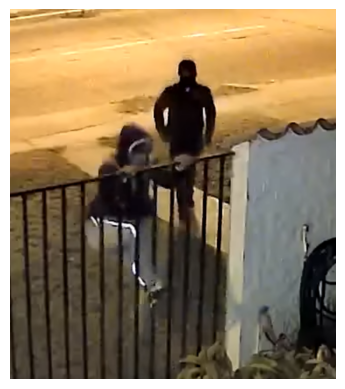

In [89]:
test_image = Image.open('Screenshot_3.png')
plt.axis('off')
plt.imshow(test_image)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# put the model in evaluation mode
img = get_image_tensor('Screenshot_3.png')

model.eval()
model.to('cpu')
with torch.no_grad():
    prediction = model([img.to('cpu')])

In [12]:
prediction

[{'boxes': tensor([[232.0010,  78.6706, 351.9415, 408.8701],
          [184.4668,  75.5388, 369.3332, 566.6500],
          [135.9698, 190.1630, 279.4131, 500.6488],
          [420.4037, 507.1678, 456.4613, 597.1441],
          [125.7871, 132.6839, 359.3971, 435.7137],
          [446.2152, 554.1733, 488.3644, 626.8292],
          [118.9211, 271.6493, 354.8214, 449.6713],
          [136.5871, 228.1481, 252.2045, 366.0835]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1]),
  'scores': tensor([0.9797, 0.8279, 0.6429, 0.4800, 0.3083, 0.1741, 0.1023, 0.0863])}]

[{'boxes': tensor([[232.0010,  78.6706, 351.9415, 408.8701],
        [184.4668,  75.5388, 369.3332, 566.6500],
        [135.9698, 190.1630, 279.4131, 500.6488],
        [420.4037, 507.1678, 456.4613, 597.1441],
        [125.7871, 132.6839, 359.3971, 435.7137],
        [446.2152, 554.1733, 488.3644, 626.8292],
        [118.9211, 271.6493, 354.8214, 449.6713],
        [136.5871, 228.1481, 252.2045, 366.0835]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1]), 'scores': tensor([0.9797, 0.8279, 0.6429, 0.4800, 0.3083, 0.1741, 0.1023, 0.0863])}]


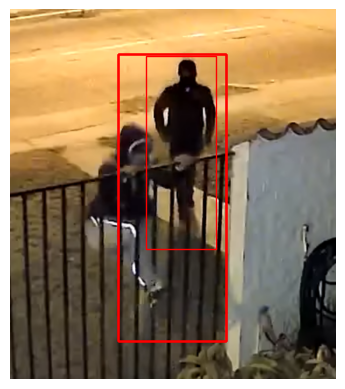

In [26]:
plot_image_from_model_output(img, model, confidence=0.8)

In [21]:
pytorch_fasterrcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 92.0MB/s]


[{'boxes': tensor([[245.9273,  84.4857, 349.9882, 366.0190],
        [137.8007, 258.5619, 196.6101, 369.8987],
        [490.7695, 377.7628, 557.0000, 583.0903],
        [130.2091, 241.0058, 235.9812, 448.1668],
        [158.1498,  95.6430, 557.0000, 292.6266],
        [177.9607, 193.4170, 245.3758, 275.6554],
        [129.4776, 324.3065, 222.5454, 451.2575],
        [175.1713, 193.4035, 245.8600, 269.0734],
        [173.0074, 263.3864, 382.1418, 599.1945],
        [211.1601,  97.8759, 374.9045, 593.7285],
        [164.2971, 163.4339, 337.0197, 385.2158],
        [  8.0027, 278.0831, 362.3902, 622.7114],
        [229.5774, 268.3251, 317.5945, 368.2090],
        [132.8004, 190.9477, 267.4028, 539.5439],
        [ 15.0119, 261.4164, 310.3419, 629.5875],
        [134.1601, 254.1552, 194.0681, 367.8002],
        [132.7684, 285.1230, 246.0899, 490.6564],
        [194.8380, 234.4782, 390.8996, 272.8209],
        [170.6350, 144.3737, 241.0216, 177.6098],
        [175.8715, 193.0141, 244.4906, 

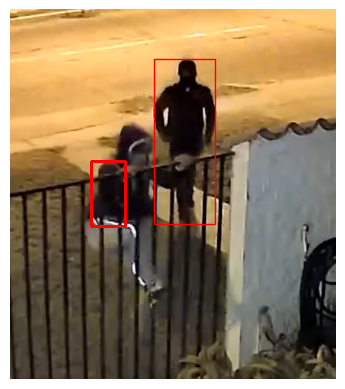

In [27]:
plot_image_from_model_output(img, pytorch_fasterrcnn, confidence=0.6)

[{'boxes': tensor([[177.1678, 113.5156, 289.5899, 390.0215],
        [249.6282,  97.6865, 376.4808, 381.1573],
        [158.4387,  83.9332, 400.1606, 385.8491],
        [  1.7890, 116.1567, 167.9943, 385.0944],
        [ 60.8104, 139.7768, 375.6337, 339.3970],
        [157.6379, 119.1838, 381.1699, 282.2152],
        [322.5060, 273.1175, 374.8474, 368.9644],
        [625.4933, 114.6154, 748.0000, 384.9946],
        [136.2879, 220.7424, 161.5466, 292.3004],
        [  6.8298, 195.6188, 182.9296, 331.8255],
        [218.4869, 127.3443, 280.7468, 373.4537],
        [313.6333, 206.6539, 376.0635, 371.7509],
        [259.6740,  45.3666, 359.8126, 124.6744],
        [150.4985, 198.7536, 287.6099, 331.5786]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'scores': tensor([0.9929, 0.9862, 0.7272, 0.5790, 0.4035, 0.3741, 0.3427, 0.2294, 0.2199,
        0.2166, 0.1926, 0.0628, 0.0612, 0.0563])}]


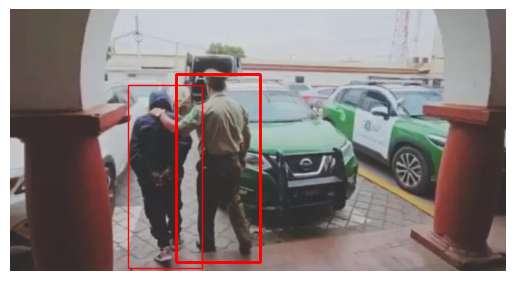

In [28]:
img2 = get_image_tensor('Screenshot_1.png')
plot_image_from_model_output(img2, model, confidence=0.8)

[{'boxes': tensor([[2.2829e+02, 9.4461e+01, 3.6379e+02, 3.7394e+02],
        [1.7670e+02, 1.2449e+02, 2.7472e+02, 3.7882e+02],
        [4.6049e+02, 1.1005e+02, 6.6544e+02, 2.7593e+02],
        [4.3225e+02, 1.1597e+02, 4.9311e+02, 1.4285e+02],
        [2.8956e+02, 1.0469e+02, 5.2730e+02, 3.1054e+02],
        [3.8496e+02, 1.0947e+02, 5.8461e+02, 2.9258e+02],
        [2.5983e+02, 6.6637e+01, 3.4321e+02, 1.3559e+02],
        [1.6564e+02, 8.3642e+01, 5.2594e+02, 3.1051e+02],
        [4.1995e+02, 1.1225e+02, 4.5478e+02, 1.3231e+02],
        [7.2595e+00, 1.4007e+02, 1.6473e+02, 3.8689e+02],
        [6.2125e+02, 1.1801e+02, 7.4525e+02, 3.8098e+02],
        [2.4850e+02, 1.0606e+02, 4.8970e+02, 2.3983e+02],
        [1.4491e+02, 2.2332e+02, 2.4392e+02, 3.8771e+02],
        [2.1704e+02, 3.5468e+02, 2.4695e+02, 3.8357e+02],
        [1.3982e+02, 6.5113e+01, 4.0154e+02, 1.7109e+02],
        [4.1257e+00, 1.5818e+02, 1.6889e+02, 3.8419e+02],
        [5.6058e+02, 1.1419e+02, 6.5715e+02, 1.6343e+02],
   

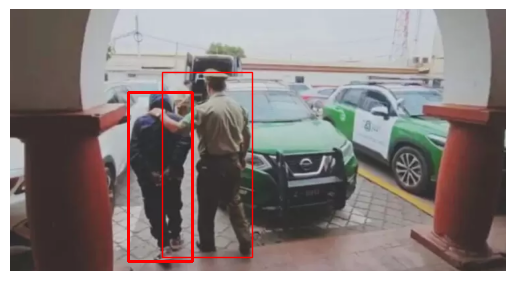

In [29]:
plot_image_from_model_output(img2, pytorch_fasterrcnn, confidence=0.8)

# Conclusión

Como podemos observar, los resultados que se obtuvieron al hace un fine-tuning al modelo de Faster RCNN con ResNet50 de backbone fueron similares al modelo original, lo cuál tiene sentido debido a que hicimos transfer learning al modelo nuevo. Cabe recalcar que al haber trabajado con aproximadamente 500 imágenes, el valor que el dataset nuevo agrega al modelo original es poco, además, lo adaptamos solamente para que identifique personas, mientras que la lógica del modelo anterior está adaptada para reconocer 91 tipos de objetos, lo cuál indica que el modelo nuevo puede ser inferior al original.
Sin embargo, se lograron resultados decentes y se cumplieron los objetivos de entrenar un modelo de object detection.

El trabajo realizado se enfocó en la problemática de detección de objetos en cámaras, acorde a mi proyecto de título DTAM.